# Work Description

In the previous notebook AutoMPG_EDA, we introduced the dataset AutoMPG, described its content and analysed the different relationships between our target variable 'MPG' and the other discret and continuous variables present in the dataset.  

Now, we will proceed to construct, assess, and tune various regression models using the scikit-learn packages. This notebook "AutoMPG_Comparing_ML_Models", details this phase where we aim to identify the most suitable model for our prediction task.




In [ ]:
from __future__ import absolute_import, print_function, division
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, Normalizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import make_scorer, r2_score, mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb

sns.set_theme(style="whitegrid", palette="Set2")

%matplotlib inline

## Task 1: Loading the data

In [2]:
dataset_path= 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']


In [3]:
dataset_raw= pd.read_csv(dataset_path, names=column_names, na_values='?', comment= "\t", sep=" ", skipinitialspace=True )

In [4]:
dataset_raw.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


In [5]:
dataset_raw.shape

(398, 8)

In [ ]:
dataset_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           398 non-null    float64
 1   Cylinders     398 non-null    int64  
 2   Displacement  398 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        398 non-null    float64
 5   Acceleration  398 non-null    float64
 6   Model Year    398 non-null    int64  
 7   Origin        398 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 25.0 KB


# Task 2:  Preparing the data for the training

### 2.1 Cleaning the data

In our previous notebook (AutoMPG_EDA), We have analysed the missing data and explained why we should drop them from the dataset. 

In [6]:
dataset_raw.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [7]:
df= dataset_raw.copy()

In [8]:
df.dropna(inplace=True)

In [ ]:
df.shape

(392, 8)

### 2.2. Encoding the data

The 'Origin' feature is a categorical variable representing the country of origin for each car. In this dataset, the code '1' corresponds to the USA, '2' to Europe, and '3' to Japan. These values are nominal and do not imply any order or ranking. To appropriately handle this feature in our machine learning model, we will apply one-hot encoding, which converts each category into a separate binary column, ensuring that the model does not assume any ordinal relationship among the categories.

In the other hand, the orther 'ordinal variables' like "Model Year" and "Cylinders" have a meaningful order and magnitude, which means that their values represent a ranking or progression that should be preserved in the encoding process. The one-hot encoding of these variables might not be suitable treats each category as independent, which can lead to a loss of the ordinal information. For example, the progression from 4 to 6 to 8 cylinders is lost when these values are converted into separate binary columns.







In [9]:
#coding the Origin.
origin = df.pop('Origin')

In [10]:
df['USA'] = (origin==1) * 1
df['Europe']= (origin==2) * 1
df['Japan']= (origin==3) * 1
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,0,0


In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   USA           392 non-null    int64  
 8   Europe        392 non-null    int64  
 9   Japan         392 non-null    int64  
dtypes: float64(5), int64(5)
memory usage: 33.7 KB


In [36]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,392.0,23.445918,7.805007,9.0,17.000,22.75,29.000,46.6
Cylinders,392.0,5.471939,1.705783,3.0,4.000,4.00,8.000,8.0
Displacement,392.0,194.411990,104.644004,68.0,105.000,151.00,275.750,455.0
Horsepower,392.0,104.469388,38.491160,46.0,75.000,93.50,126.000,230.0
Weight,392.0,2977.584184,849.402560,1613.0,2225.250,2803.50,3614.750,5140.0
Acceleration,392.0,15.541327,2.758864,8.0,13.775,15.50,17.025,24.8
Model Year,392.0,75.979592,3.683737,70.0,73.000,76.00,79.000,82.0
USA,392.0,0.625000,0.484742,0.0,0.000,1.00,1.000,1.0
Europe,392.0,0.173469,0.379136,0.0,0.000,0.00,0.000,1.0
Japan,392.0,0.201531,0.401656,0.0,0.000,0.00,0.000,1.0


### 2.3 Scaling the data

We can notice from the previous table that our features have different ranges. Often, if we use them without scaling, the features with large absolute values will dominate the prediction outcome. Instead, to give each feature a fair opportunity to contribute to the prediction outcome, we must bring all features on the same scale. The two most common scaling techniques are:

- **Normalization**: This scaling technique restricts the feature values between 0 and 1. To apply normalization, we subtract the minimum feature value and divide it by the range (difference between min and max) of that feature. Normalization may not be a good technique if some of our features have a sharp skew or have a few extreme outliers.
- **Standardization**: This technique transforms the feature data distribution to the standard normal distribution. We can implement this technique by subtracting the mean and dividing it by the standard deviation. This technique is generally preferred if the feature has a sharp skew or a few extreme outliers.

In our previous analysis, we did not notice the presence of extreme outliers or significant skewness in any of our features. Most of them follow a Gaussian distribution with moderate skewness. However, this is not sufficient to determine the most suitable scaling method for our dataset. Therefore, we will compare the performance of our baseline model (Logistic Regression) under the following scenarios:

- Training the baseline model without scaling
- Training the baseline model with normalization as the scaling method
- Training the baseline model with standardization as the scaling method
- Comparing and choosing the best scaling method

In this notebook, we will use the sklearn pipeline to conduct our experiments. This approach is faster and more concise for experimenting with different training pipelines. Scaling will be defined as one step in these pipelines.

In this notebook, we will be using sklearn pipline to conduct our different experimentations. It is faster and more conscise way to experiment different training pipelines. Scaling will defined as one step of these pipelines. 

### 2.4 Splitting the data into training and the testing sets

In [11]:
#Seperating Input and ouput variable
y = df['MPG']
X= df.drop('MPG', axis=1)

In [12]:
#Splitting the data into training and testing data
X_train, X_test, Y_train, Y_test= train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)


(313, 9)
(313,)
(79, 9)
(79,)


# Task 3: Training baseline Model with Linear Regression and compare scaling methods



### 3.1 Training LR Model without data scaling

In [ ]:
#Fitting the LR model to our training data
lr=LinearRegression()
lr.fit(X_train, Y_train)

In [23]:
#A function to evaluate the results of the  model on the testing set
def evaluating_model(model, model_name, X_test, y_test) :
  test_score = model.score(X_test, Y_test)
  Y_pred = model.predict(X_test)
  mse= mean_squared_error(Y_test, Y_pred)
  mae= mean_absolute_error(Y_test, Y_pred)
  mape= mean_absolute_percentage_error(Y_test, Y_pred)
  print("## Evaluation of the "+ model_name + " Model \n" )
  print(f" -Testing score (R-2): {test_score:.3f}")
  print(f" -Testing set Mean Absolute Error : {mae:.3f} MPG")
  print(f" -Testing set Mean Square Error : {mse:.3f}")
  print(f" -Testing set Mean Absolute Percentage Error : {mape:.3f}")
  return Y_pred


In [24]:
#A function to Plot the predictions of the Testing set
def plotting_prediction (y_test, y_pred) :
  a = plt.axes(aspect='equal')
  plt.scatter(y_test, y_pred)
  plt.xlabel('True Values [MPG]')
  plt.ylabel('Predictions [MPG]')
  lims = [0, 50]
  plt.xlim(lims)
  plt.ylim(lims)
  _ = plt.plot(lims, lims)

In [25]:
#Evaluating the LR baseline model
Y_pred= evaluating_model(lr, "LinearRegression_NoScaling", X_test, Y_test)

## Evaluation of the LinearRegression Model 

 -Testing score (R-2): 0.792
 -Testing set Mean Absolute Error : 2.462 MPG
 -Testing set Mean Square Error : 10.602
 -Testing set Mean Absolute Percentage Error : 0.120


**Plotting the predictions**

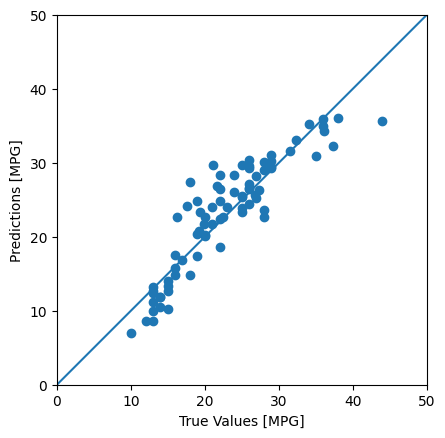

In [26]:
plotting_prediction(Y_test, Y_pred)

### 3.2 Training baseline model with different data scaling methods

We will be comparing 2 different scaling methods often used in the litterature : Normalizer and StandardScaler. To ease the data preprocessing and model evalution, we will be creating a training pipeline using sklearn.

In [30]:
#A generic function to create a training pipeline based of the estimator and the scaling method passed as params
def train_model_scaler(estimator , scalar, X_train, Y_train) :
  pipeline = Pipeline(steps=[
      ('scaler', scalar),
      ('model', estimator)
  ])
  # Training the model
  pipeline.fit(X_train, Y_train)

  return pipeline

In [31]:
#Creating and evaluation the baseline model with the Normlizer method as a scaler
lr_normalizer = train_model_scaler( LinearRegression(), Normalizer(), X_train, Y_train)
Y_pred_norm = evaluating_model(lr_normalizer, "LinearRegression_Normalizer", X_test, Y_test)


## Evaluation of the LinearRegression_normalizer Model 

 -Testing score (R-2): 0.844
 -Testing set Mean Absolute Error : 2.086 MPG
 -Testing set Mean Square Error : 7.939
 -Testing set Mean Absolute Percentage Error : 0.093


In [32]:
#Creating and evaluation the baseline model with the StandardScaler method as a scaler
lr_standard = train_model_scaler( LinearRegression(), StandardScaler(), X_train, Y_train)
Y_pred_standard = evaluating_model(lr_standard, "LinearRegression_Standard", X_test, Y_test)

## Evaluation of the LinearRegression_Standard Model 

 -Testing score (R-2): 0.792
 -Testing set Mean Absolute Error : 2.462 MPG
 -Testing set Mean Square Error : 10.602
 -Testing set Mean Absolute Percentage Error : 0.120


**Observations** : Based on the evaluation results we obtained from comparing the two preprocessing methods (Normalizer and StandardScaler) with a Linear Regression model on my AutoMPG dataset, it appears that using the Normalizer yields better performance metrics than the StandardScaler and this is according to the 4 metrics we used. The superior performance of the Normalizer pipeline suggests that for this particular dataset and model, scaling each sample to unit norm is more effective than standardizing features to zero mean and unit variance. These empirical resultats are in contrast with  the fact that StandardScaler is more recommanded to use with linear models. The obtained resultats could be due to several reasons, mainly related to the nature of the data, their particular distributions and the relationships between the features.


### 3.3 Validating the scaling methods comparaison results using cross validation 

In [42]:
# Custom scoring dictionary
scoring = {
    'R2': 'r2',
    'MAE': make_scorer(mean_absolute_error),
    'MSE': make_scorer(mean_squared_error),
    'MAPE': make_scorer(mean_absolute_percentage_error)
}

# Function to evaluate model using cross-validation and return the mean scores
def cross_val_evaluate_model(estimator , scalar, X, y, scoring, cv=5):
  pipeline = Pipeline(steps=[
    ('scaler', scalar),
    ('model', estimator)
  ])
  scores = cross_validate(pipeline, X, y, scoring=scoring, cv=cv, return_train_score=False)
  mean_scores = {metric: np.mean(scores[f'test_{metric}']) for metric in scoring.keys()}
  return mean_scores

# Evaluate both models with cross-validation
results_normalizer = cross_val_evaluate_model(LinearRegression(), Normalizer() , X, y, scoring, cv=5)
results_standard = cross_val_evaluate_model(LinearRegression(), StandardScaler(), X, y, scoring, cv=5)

print('Cross-Validation Results with Normalizer: \n ', results_normalizer)
print('Cross-Validation Results with StandardScaler: \n ', results_standard)

Cross-Validation Results with Normalizer: 
  {'R2': 0.696048583992838, 'MAE': 2.4451038742194617, 'MSE': 11.124315378920857, 'MAPE': 0.10622766082724563}
Cross-Validation Results with StandardScaler: 
  {'R2': 0.5948758459784014, 'MAE': 3.0376456313452485, 'MSE': 15.043424403521323, 'MAPE': 0.14439591276195834}


**Conclusion:**

Based on the cross-validation results, it is evident that the Normalizer preprocessing method outperforms the StandardScaler in all evaluated metrics. The model with the Normalizer demonstrates better predictive accuracy and lower error rates. Consequently, for the given Auto MPG dataset and Linear Regression model, using the Normalizer as the data scaling method is the more effective choice

# Task 4: Comparing different training models

### 4.1 Train and evaluate the candidate ML models

In [43]:
#Function to train and compare a list of ML algorithms passed as argument
def train_compare_models(models_names, X_train, y_train, X_test, y_test) :
  results={}
  # List of supported model, defined using default parameters
  supported_models = {
        "LinearRegression": LinearRegression(),
        "RidgeRegression": Ridge(alpha=1.0),
        "LassoRegression": Lasso(alpha=0.1),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
        "GradientBoosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
        "SupportVectorRegression": SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1),
        "K-Nearest-Neighbors": KNeighborsRegressor(n_neighbors=5),
        "DecisionTree": DecisionTreeRegressor(random_state=42),
        "XGBoost": xgb.XGBRegressor(n_estimators=100, seed=42)
  }

  for model_name in models_names :
    if model_name not in supported_models :
      print("Not supported model : "+ model_name)
      continue
    else :
      # Creating a training pipeline with numerical normalization of numerical variables
      model = supported_models[model_name]
      pipeline_rf = Pipeline(steps=[
          ('scaler', Normalizer()),
          ('model', model)
      ])
      # Training the model
      pipeline_rf.fit(X_train, Y_train)

      # Evaluating the model
      train_score = pipeline_rf.score(X_train, Y_train)
      test_score = pipeline_rf.score(X_test, Y_test)

      #Computing the predictions
      #Predicting using the creating pipeline
      Y_pred = pipeline_rf.predict(X_test)

      #Evaluating the results of the baseline model
      mse= mean_squared_error(Y_test, Y_pred)
      mae= mean_absolute_error(Y_test, Y_pred)
      mape= mean_absolute_percentage_error(Y_test, Y_pred)
      results[model_name] = {
          'r2-trainig' : train_score,
          'r2-testing' : test_score,
          'mae' : mae,
          'mse' : mse ,
          'mape' : mape,
      }

  return results


In [54]:
# Cadidate ML estimators to be compared
estimators = ["LinearRegression", "RidgeRegression", "LassoRegression", "RandomForest",
               "GradientBoosting", "SupportVectorRegression", "K-Nearest-Neighbors",
               "DecisionTree", "XGBoost"]

# Compare models
results = train_compare_models(estimators, X_train, Y_train, X_test, Y_test)

df_results = pd.DataFrame.from_dict(results, orient='index')

df_results=df_results.sort_values('mape', ascending=True)


Training : LinearRegression.... 

Training : RidgeRegression.... 

Training : LassoRegression.... 

Training : RandomForest.... 

Training : GradientBoosting.... 

Training : SupportVectorRegression.... 

Training : K-Nearest-Neighbors.... 

Training : DecisionTree.... 

Training : XGBoost.... 



,r2-trainig,r2-testing,mae,mse,mape
XGBoost,0.999993,0.821216,1.984970,9.125246,0.091277
LinearRegression,0.866624,0.844462,2.085824,7.938775,0.092773
GradientBoosting,0.971790,0.843598,2.060014,7.982851,0.094031
RandomForest,0.975137,0.787515,2.294177,10.845372,0.103754
K-Nearest-Neighbors,0.857981,0.752493,2.663291,12.632881,0.120064
DecisionTree,1.000000,0.643731,2.874684,18.184177,0.130412
SupportVectorRegression,0.253159,0.282010,4.721326,36.646645,0.227988
RidgeRegression,0.119781,0.112485,5.440335,45.299284,0.279283
LassoRegression,0.026211,0.015532,5.785169,50.247814,0.297062


<ipython-input-70-4d2bb960fe84>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_results.index, y='mae', data=df_results, palette="Set2")


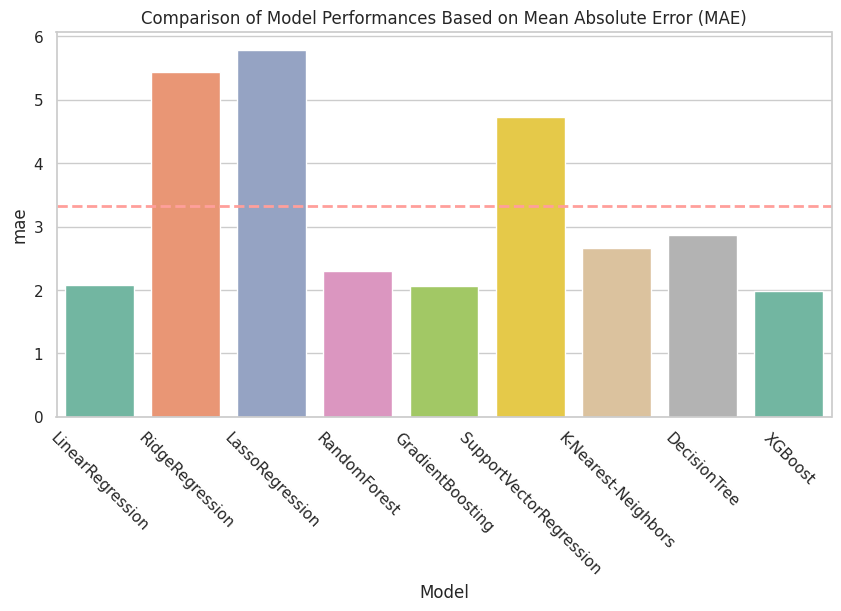

In [70]:
plt.figure(figsize=(10, 5))
sns.barplot(x=df_results.index, y='mae', data=df_results, palette="Set2")
plt.axhline(df_results.mae.mean(),color='r',linestyle='dashed',linewidth=2)
plt.title("Comparison of Model Performances Based on Mean Absolute Error (MAE)")
plt.xlabel("Model")
plt.xticks(rotation = -45)
plt.show()


<ipython-input-76-40edf03d5b95>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar= sns.barplot(x=df_results.index, y='mape', data=df_results, palette="Set2")


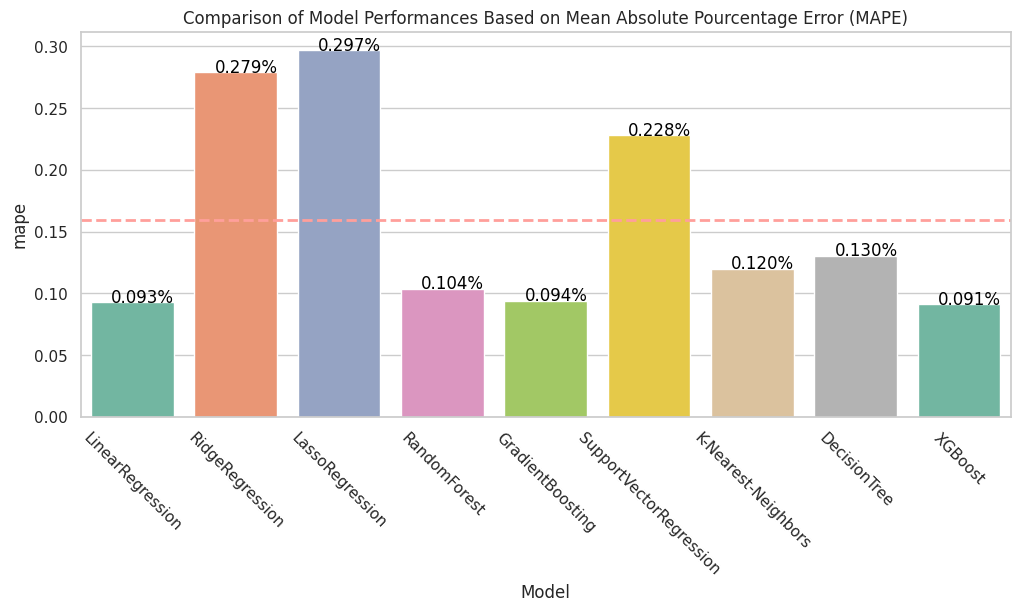

In [76]:
plt.figure(figsize=(12, 5))
bar= sns.barplot(x=df_results.index, y='mape', data=df_results, palette="Set2")
plt.axhline(df_results.mape.mean(),color='r',linestyle='dashed',linewidth=2)
plt.title("Comparison of Model Performances Based on Mean Absolute Pourcentage Error (MAPE)")
plt.xlabel('Model')
plt.xticks(rotation = -45)
for p in bar.patches :
  plt.text(p.get_x()+0.5, p.get_height(), f'{p.get_height():.3f}%', ha='center', color='black')
plt.show()

### 4.2 Analysing the results
//Todo

# Task 5: Fine-tuning for the best model
//TODO

# Task 6 : Saving the final model
//TODO